# Visualizing Eye Tracking

### Environment Setup

In [1]:
from pynwb import NWBHDF5IO
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from dandi import dandiapi

### Downloading NWB Files
If you don't already have files to analyze, you can use data from The Allen Institute's `Visual Coding - Neuropixels` dataset. If you want to choose your own files to download, set `dandiset_id`, `dandi_stim_filepath`, `dandi_lfp_filepath` accordingly.

In [2]:
dandiset_id = "000253"
dandi_filepath = "sub-1169714184/sub-1169714184_ses-1180116198.nwb"
download_loc = "../../../data/glo"

In [3]:
filename = dandi_filepath.split("/")[-1]
my_dandiset = dandiapi.DandiAPIClient(token="7b74c449992670033c1c6018648afcac078527a9").get_dandiset(dandiset_id)
print(f"Got dandiset {my_dandiset}")

A newer version (0.46.6) of dandi/dandi-cli is available. You are using 0.46.3


Got dandiset DANDI:000253/draft


In [ ]:
file = my_dandiset.get_asset_by_path(dandi_filepath)
# this may take awhile, especially if the file to download is large
file.download(f"{download_loc}/{filename}")

print(f"Downloaded file to {download_loc}/{filename}")

### Extracting Eye Tracking Data

In [4]:
stim_filepath = f"{download_loc}/{filename}"

In [5]:
io = NWBHDF5IO(stim_filepath, mode="r", load_namespaces=True)
nwb = io.read() 

C:\Users\carter.peene\AppData\Local\Programs\Python\Python39\lib\site-packages\hdmf\spec\namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.5.0 because version 1.5.1 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
C:\Users\carter.peene\AppData\Local\Programs\Python\Python39\lib\site-packages\hdmf\spec\namespace.py:531: UserWarning: Ignoring cached namespace 'core' version 2.4.0 because version 2.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
C:\Users\carter.peene\AppData\Local\Programs\Python\Python39\lib\site-packages\hdmf\spec\namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.1.0 because version 0.2.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


In [14]:
blink_times = nwb.acquisition["EyeTracking"].likely_blink
print(blink_times)

likely_blink pynwb.base.TimeSeries at 0x2078241917872
Fields:
  comments: no comments
  conversion: 1.0
  data: <HDF5 dataset "data": shape (478660,), type "|b1">
  description: blinks
  interval: 1
  offset: 0.0
  resolution: -1.0
  timestamps: eye_tracking abc.EllipseSeries at 0x2078242500464
Fields:
  angle: <HDF5 dataset "angle": shape (478660,), type "<f8">
  area: <HDF5 dataset "area": shape (478660,), type "<f8">
  area_raw: <HDF5 dataset "area_raw": shape (478660,), type "<f8">
  comments: no comments
  conversion: 1.0
  data: <HDF5 dataset "data": shape (478660, 2), type "<f8">
  description: no description
  height: <HDF5 dataset "height": shape (478660,), type "<f8">
  interval: 1
  offset: 0.0
  reference_frame: nose
  resolution: -1.0
  timestamp_link: (
    pupil_tracking <class 'abc.EllipseSeries'>,
    corneal_reflection_tracking <class 'abc.EllipseSeries'>,
    likely_blink <class 'pynwb.base.TimeSeries'>
  )
  timestamps: <HDF5 dataset "timestamps": shape (478660,), t

In [7]:
print(blink_times.data[:100])

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False]


In [53]:
# eye_tracking = nwb.acquisition["EyeTracking"].corneal_reflection_tracking
eye_tracking = nwb.acquisition["EyeTracking"].pupil_tracking
# eye_tracking = nwb.acquisition["EyeTracking"].eye_tracking
timestamps = eye_tracking.timestamps
print(eye_tracking)

pupil_tracking abc.EllipseSeries at 0x2078241921152
Fields:
  angle: <HDF5 dataset "angle": shape (478660,), type "<f8">
  area: <HDF5 dataset "area": shape (478660,), type "<f8">
  area_raw: <HDF5 dataset "area_raw": shape (478660,), type "<f8">
  comments: no comments
  conversion: 1.0
  data: <HDF5 dataset "data": shape (478660, 2), type "<f8">
  description: no description
  height: <HDF5 dataset "height": shape (478660,), type "<f8">
  interval: 1
  offset: 0.0
  reference_frame: nose
  resolution: -1.0
  timestamps: eye_tracking abc.EllipseSeries at 0x2078242500464
Fields:
  angle: <HDF5 dataset "angle": shape (478660,), type "<f8">
  area: <HDF5 dataset "area": shape (478660,), type "<f8">
  area_raw: <HDF5 dataset "area_raw": shape (478660,), type "<f8">
  comments: no comments
  conversion: 1.0
  data: <HDF5 dataset "data": shape (478660, 2), type "<f8">
  description: no description
  height: <HDF5 dataset "height": shape (478660,), type "<f8">
  interval: 1
  offset: 0.0
  r

In [74]:
print(timestamps[0])
print(timestamps[-2])

2.07742
7979.68481


In [78]:
timestamps[:100]

array([2.07742, 2.09598, 2.37742, 2.38024, 2.38235, 2.38458, 2.38667,
       2.3912 , 2.39361, 2.39581, 2.40095, 2.40269, 2.41112, 2.44417,
       2.45851, 2.47527, 2.49421, 2.50797, 2.52529, 2.54103, 2.57798,
       2.58003, 2.59192, 2.60806, 2.62668, 2.64199, 2.65779, 2.67528,
       2.69126, 2.70765, 2.72466, 2.74371, 2.75863, 2.7745 , 2.7919 ,
       2.8095 , 2.82491, 2.84203, 2.85869, 2.8772 , 2.89107, 2.90863,
       2.92452, 2.9418 , 2.95766, 2.97532, 2.99576, 3.00898, 3.02431,
       3.04134, 3.06081, 3.07449, 3.09222, 3.10786, 3.12458, 3.14191,
       3.15832, 3.17528, 3.19141, 3.20796, 3.22591, 3.24185, 3.25892,
       3.27529, 3.29124, 3.30865, 3.32517, 3.34189, 3.35866, 3.3762 ,
       3.39133, 3.40782, 3.4244 , 3.44116, 3.45859, 3.47469, 3.49172,
       3.50826, 3.5251 , 3.54177, 3.55849, 3.57498, 3.59093, 3.6077 ,
       3.62604, 3.64175, 3.65857, 3.6754 , 3.6922 , 3.70884, 3.72543,
       3.74197, 3.75949, 3.77522, 3.7925 , 3.80859, 3.82453, 3.84181,
       3.85854, 3.87

In [75]:
start_time = 1000
end_time = 2000

In [76]:
# get data indices from times

start_idx, end_idx = None, None
for i, ts in enumerate(timestamps):
    if not start_idx and ts >= start_time:
        start_idx = i
    if start_idx and ts >= end_time:
        end_idx = i
        break

if start_idx == None or end_idx == None:
    raise ValueError("Time bounds not found within eyetracking timestamps")


In [79]:
# make time axis
time_axis = np.arange(start_time, end_time)

Text(0, 0.5, 'height')

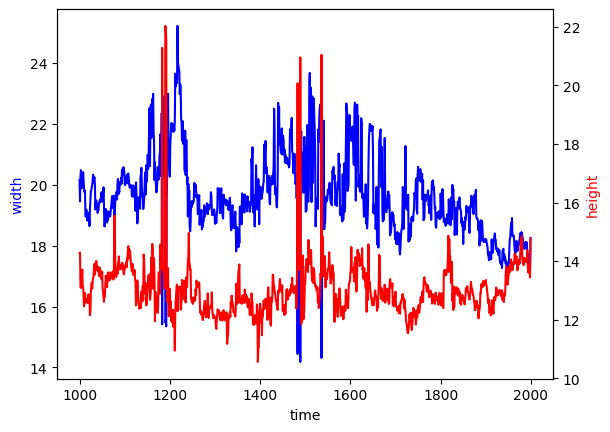

In [81]:
fig, ax1 = plt.subplots()
ax1.set_xlabel('time')
ax1.plot(time_axis, eye_tracking.width[start:end], color='b')
ax1.set_ylabel('width', color='b')
ax2 = ax1.twinx()
ax2.plot(time_axis, eye_tracking.height[start:end], color='r')
ax2.set_ylabel('height', color='r')

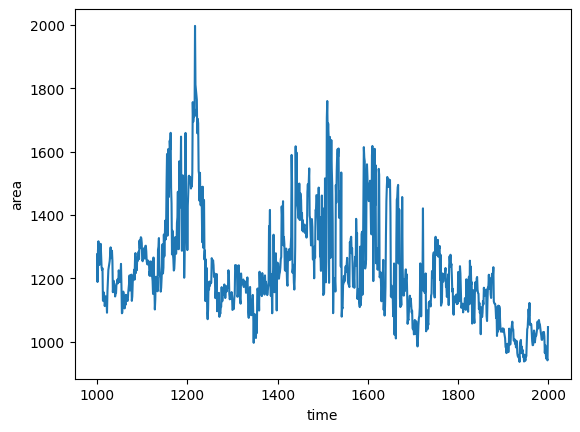

In [87]:
fig, ax1 = plt.subplots()
ax1.set_xlabel('time')
ax1.set_ylabel('area')
ax1.plot(time_axis, eye_tracking.area[start:end])

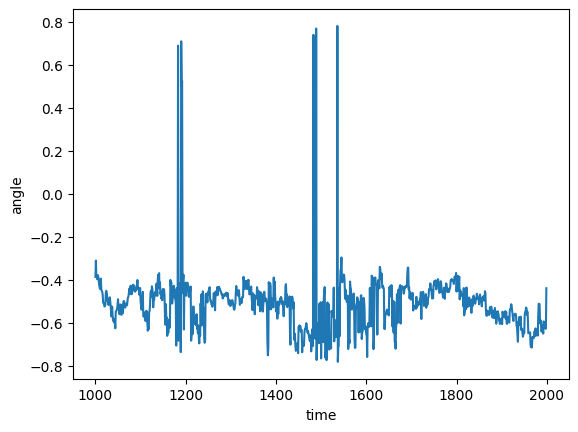

In [88]:
fig, ax = plt.subplots()
angle = np.array(eye_tracking.angle)
ax.set_xlabel('time')
ax.set_ylabel('angle')
ax.plot(time_axis, angle[start:end])

In [47]:
%matplotlib inline
xs = np.array([point[0] for point in eye_tracking.data])
ys = np.array([point[1] for point in eye_tracking.data])
print(xs.shape)
print(ys.shape)
print(type(eye_tracking.area))
print(eye_tracking.area.shape)

(478660,)
(478660,)
<class 'h5py._hl.dataset.Dataset'>
(478660,)


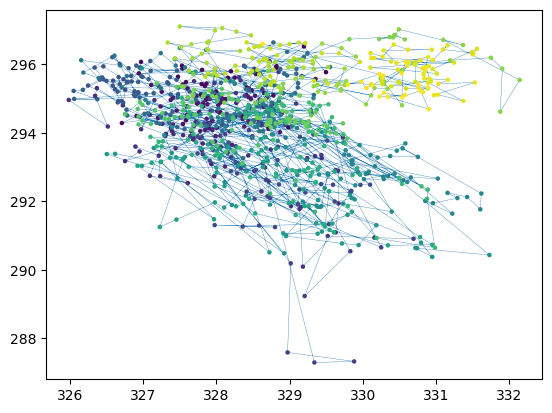

In [48]:
colors = plt.cm.viridis(np.linspace(0, 1, end-start))
plt.plot(xs[start:end], ys[start:end], zorder=0, linewidth=0.25)
plt.scatter(xs[start:end], ys[start:end], s=5, c=colors, zorder=1)
plt.show()